In [2]:
# This script can be directly run in Google Colab.

# Install necessary libraries
!pip install gensim kagglehub

import pandas as pd
import numpy as np
import re
import string
import gensim
import gensim.downloader as api
import kagglehub
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm # Use tqdm.notebook for better display in notebooks



In [3]:
# Download the dataset from KaggleHub
dataset_path = kagglehub.dataset_download("lakshmi25npathi/imdb-dataset-of-50k-movie-reviews")

print(f"Dataset downloaded to: {dataset_path}")

# Load the dataset
imdb_df = pd.read_csv(f"{dataset_path}/IMDB Dataset.csv")



Dataset downloaded to: /kaggle/input/imdb-dataset-of-50k-movie-reviews



Dataset head:


,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1



Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 781.4+ KB
Review character count statistics:
count    50000.000000
mean      1309.431020
std        989.728014
min         32.000000
25%        699.000000
50%        970.000000
75%       1590.250000
max      13704.000000
Name: review_char_count, dtype: float64

Review word count statistics:
count    50000.000000
mean       231.156940
std        171.343997
min          4.000000
25%        126.000000
50%        173.000000
75%        280.000000
max       2470.000000
Name: review_word_count, dtype: float64

Sentiment distribution:
sentiment
1    25000
0    25000
Name: count, dtype: int64


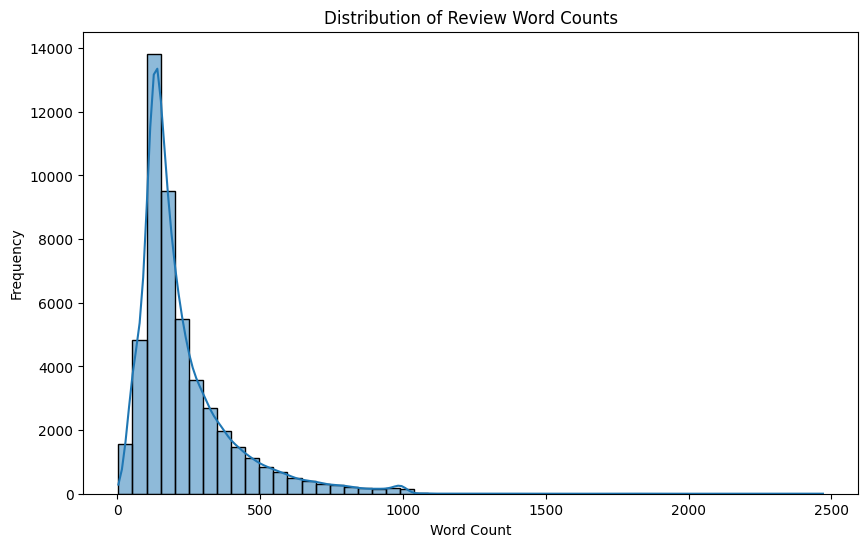

In [4]:
# Convert sentiment labels to numerical values (positive: 1, negative: 0)
imdb_df['sentiment'] = imdb_df['sentiment'].map({'positive': 1, 'negative': 0})

print("\nDataset head:")
display(imdb_df.head())

print("\nDataset Info:")
imdb_df.info()

# Calculate length of each review (character count)
imdb_df['review_char_count'] = imdb_df['review'].apply(len)

# Calculate word count for each review
imdb_df['review_word_count'] = imdb_df['review'].apply(lambda x: len(x.split()))

print("Review character count statistics:")
print(imdb_df['review_char_count'].describe())

print("\nReview word count statistics:")
print(imdb_df['review_word_count'].describe())

print("\nSentiment distribution:")
print(imdb_df['sentiment'].value_counts())

# Visualize word count distribution
plt.figure(figsize=(10, 6))
sns.histplot(imdb_df['review_word_count'], bins=50, kde=True)
plt.title('Distribution of Review Word Counts')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

In [5]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'<.*?>', '', text)  # remove HTML tags
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)  # remove punctuation
    tokens = text.split()
    tokens = [w for w in tokens if w not in ENGLISH_STOP_WORDS]
    return tokens

imdb_df['tokens'] = imdb_df['review'].apply(clean_text)

def vector_average(tokens, model, vector_size):
    valid_tokens = [token for token in tokens if token in model]
    if not valid_tokens:
        return np.zeros(vector_size)
    return np.mean([model[token] for token in valid_tokens], axis=0)

print("Loading pre-trained Word2Vec model (google-news-300)...")
w2v_model = api.load("word2vec-google-news-300")
print("Generating vectors for Pre-trained W2V...")


Loading pre-trained Word2Vec model (google-news-300)...
[==================================================] 100.0% 1662.8/1662.8MB downloaded
Generating vectors for Pre-trained W2V...


In [6]:
X = np.array([vector_average(tokens, w2v_model, 300) for tokens in tqdm(imdb_df['tokens'])])
y = imdb_df['sentiment'].values

print("\nTraining custom Skip-gram model...")
# Increased epochs slightly for better custom model training
skip_model = gensim.models.Word2Vec(imdb_df['tokens'], vector_size=100, window=5, sg=1, epochs=15)
print("Generating vectors for Custom Skip-gram...")
X_skip = np.array([vector_average(tokens, skip_model.wv, 100) for tokens in tqdm(imdb_df['tokens'])])

print("\nTraining custom CBOW model...")
cbow_model = gensim.models.Word2Vec(imdb_df['tokens'], vector_size=100, window=5, sg=0, epochs=15)
print("Generating vectors for Custom CBOW...")
X_cbow = np.array([vector_average(tokens, cbow_model.wv, 100) for tokens in tqdm(imdb_df['tokens'])])

print("\nTraining custom FastText model...")
fasttext_model = gensim.models.FastText(imdb_df['tokens'], vector_size=100, window=5, epochs=15)
print("Generating vectors for Custom FastText...")
X_fast = np.array([vector_average(tokens, fasttext_model.wv, 100) for tokens in tqdm(imdb_df['tokens'])])



  0%|          | 0/50000 [00:00<?, ?it/s]


Training custom Skip-gram model...
Generating vectors for Custom Skip-gram...


  0%|          | 0/50000 [00:00<?, ?it/s]


Training custom CBOW model...
Generating vectors for Custom CBOW...


  0%|          | 0/50000 [00:00<?, ?it/s]


Training custom FastText model...
Generating vectors for Custom FastText...


  0%|          | 0/50000 [00:00<?, ?it/s]

In [7]:
def evaluate_model(X_data, y_data):
    """
    Splits data, trains a Logistic Regression classifier, and evaluates its performance.
    """
    X_train, X_test, y_train, y_test = train_test_split(
        X_data, y_data, test_size=0.2, random_state=42, stratify=y_data # Stratify for balanced classes
    )

    # Increased max_iter for convergence, using lbfgs solver for good default performance
    clf = LogisticRegression(max_iter=2000, solver='lbfgs', n_jobs=-1)
    print("  Fitting Logistic Regression model...")
    clf.fit(X_train, y_train)

    print("  Making predictions...")
    y_pred = clf.predict(X_test)

    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    print("\n  Classification Report:")
    print(classification_report(y_test, y_pred))

    return {'precision': precision, 'recall': recall, 'f1': f1}




--- Evaluating Models ---

Evaluating Pre-trained W2V:
  Fitting Logistic Regression model...
  Making predictions...

  Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.85      0.85      5000
           1       0.85      0.85      0.85      5000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000


Evaluating Custom Skip-gram:
  Fitting Logistic Regression model...
  Making predictions...

  Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.88      0.88      5000
           1       0.88      0.88      0.88      5000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000


Evaluating Custom CBOW:
  Fitting Logistic Regression model...
  Making predictio

,precision,recall,f1
Pretrained W2V,0.8482,0.8482,0.8482
Custom Skip-gram,0.8774,0.8774,0.8774
Custom CBOW,0.8747,0.8747,0.8747
Custom FastText,0.8636,0.8636,0.8636


<Figure size 1200x700 with 0 Axes>

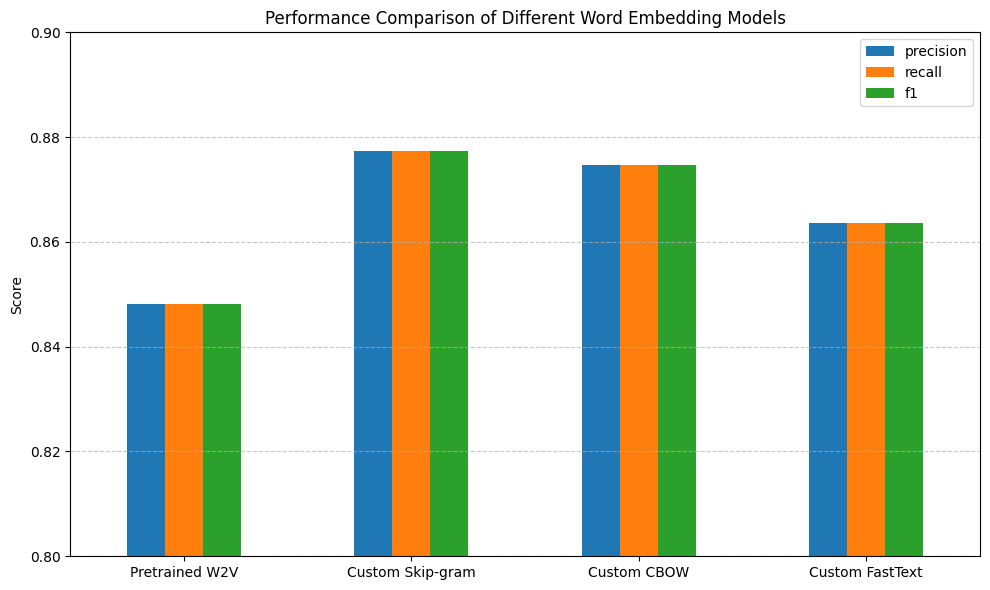

In [8]:
print("\n--- Evaluating Models ---")

model_results = {}

print("\nEvaluating Pre-trained W2V:")
model_results["Pretrained W2V"] = evaluate_model(X, y)

print("\nEvaluating Custom Skip-gram:")
model_results["Custom Skip-gram"] = evaluate_model(X_skip, y)

print("\nEvaluating Custom CBOW:")
model_results["Custom CBOW"] = evaluate_model(X_cbow, y)

print("\nEvaluating Custom FastText:")
model_results["Custom FastText"] = evaluate_model(X_fast, y)

# Display results in a DataFrame
performance_summary_df = pd.DataFrame(model_results).T
performance_summary_df = performance_summary_df[['precision', 'recall', 'f1']]
performance_summary_df = performance_summary_df.round(4)

print("\n--- Model Performance Summary ---")
display(performance_summary_df)

# Visualize performance
plt.figure(figsize=(12, 7))
performance_summary_df.plot(kind='bar', figsize=(10, 6), rot=0)
plt.title('Performance Comparison of Different Word Embedding Models')
plt.ylabel('Score')
plt.ylim(0.8, 0.9)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()